In [1]:
import os
import librosa
import librosa.display
import pandas as pd
import numpy as np
from tqdm import tqdm
import IPython.display as ipd
import matplotlib.pyplot as plt

In [9]:
audio_df = pd.read_csv("audio_dataset.csv")
audio_df.head()

,actor,gender,emotion,path
0,1,male,neutral,data/Actor_01/03-01-01-01-01-01-01.wav
1,1,male,neutral,data/Actor_01/03-01-01-01-01-02-01.wav
2,1,male,neutral,data/Actor_01/03-01-01-01-02-01-01.wav
3,1,male,neutral,data/Actor_01/03-01-01-01-02-02-01.wav
4,1,male,calm,data/Actor_01/03-01-02-01-01-01-01.wav


# Data Augmentation

In [7]:
# Noise
# rate of noise = 0.035, Noise increases as rate increases
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# Stretch
# rate of stretching audio = 0.8, Audio is streched more as rate decreases
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

# Shift
# shifts the initial part of audio at the end in left to right direction
def shift(data):
    shift_range = int(np.random.uniform(low = -5, high = 5)*1000)
    return np.roll(data, shift_range)

# Pitch
# pitch_factor = 0.7 --> adjusts the pitch of the audio
# negative values for greater pitch, positive(higher) values for lower pitch
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)


Normal Audio

In [10]:
path = np.array(audio_df['path'])[40]
data, sample_rate = librosa.load(path)

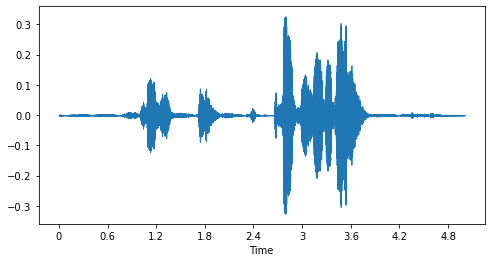

In [5]:
plt.figure(figsize=(8,4))
librosa.display.waveshow(y=data, sr=sample_rate)
ipd.Audio(path)

Audio with noise

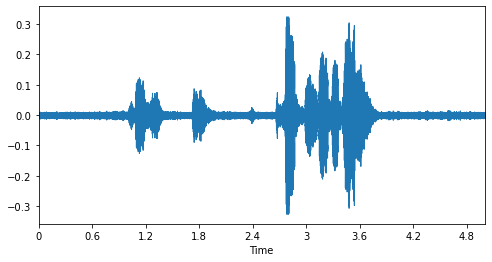

In [6]:
x = noise(data)
plt.figure(figsize=(8,4))
librosa.display.waveplot(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

Audio with stretch 

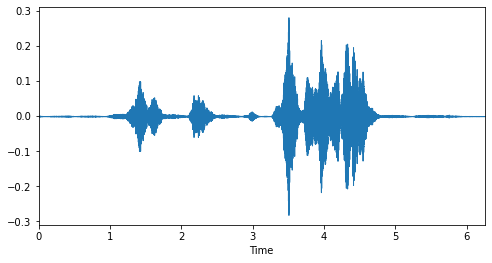

In [7]:
x = stretch(data)
plt.figure(figsize=(8, 4))
librosa.display.waveplot(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

Audio with shift

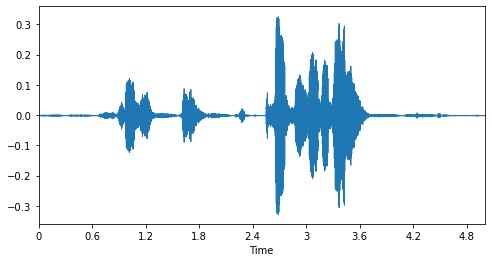

In [8]:
x = shift(data)
plt.figure(figsize=(8,4))
librosa.display.waveplot(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

Audio with pitch

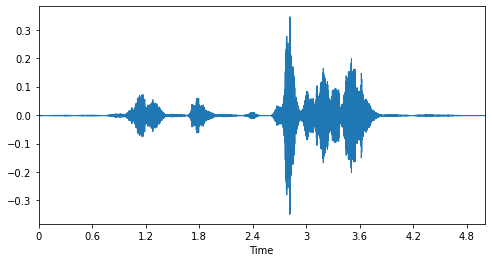

In [9]:
x = pitch(data, sample_rate)
plt.figure(figsize=(8, 4))
librosa.display.waveplot(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

# Feature Extraction

In [27]:
def feature_extraction(data):
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    return mfcc

# duration = 2.5, 
# offset = 0.6 --> considers audio of 2.5 duration starting from 0.6 sec
def get_features(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # normal data
    res1 = feature_extraction(data)
    result = np.array(res1)
    
    #data with noise
    noise_data = noise(data)
    res2 = feature_extraction(noise_data)
    result = np.vstack((result, res2))
    
    #data with stretch and pitch
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = feature_extraction(data_stretch_pitch)
    result = np.vstack((result, res3))
    
    return result

In [14]:
X, Y = [], []
for path, emotion in zip(audio_df['path'], audio_df['emotion']):
    feature = get_features(path)
    for element in feature:
        X.append(element)
        Y.append(emotion)

In [15]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)

In [16]:
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,labels
0,-655.344543,86.649872,-12.361261,28.343273,-0.276913,9.111378,-10.830962,-0.023427,-17.030333,-3.272646,...,-5.887830,4.827703,-7.893806,3.420066,-1.663579,-3.320957,-4.437192,-0.790467,-2.032093,neutral
1,-468.846883,36.201069,7.022181,11.240697,5.891850,-0.584644,-3.701114,-7.027015,-10.899846,-6.105315,...,-2.494775,-1.683088,-2.495134,-1.049956,-0.803621,-4.164983,-4.072344,-0.451641,-2.481066,neutral
2,-724.307190,84.484085,-14.169809,31.049458,-3.062177,9.604401,-14.447046,-0.219916,-20.591164,2.434902,...,-4.020089,3.011852,-8.109156,3.908098,-5.972446,-3.686382,-5.658264,2.423278,-4.886253,neutral
3,-645.409851,87.810638,-17.773392,33.468960,-0.936478,8.191231,-9.919904,-3.311972,-18.590483,-2.199426,...,-6.660094,3.893642,-8.572474,2.928271,-3.344517,-3.604979,-4.101902,-1.308776,-0.581940,neutral
4,-397.263188,22.259394,8.897292,9.042624,4.974095,0.232102,-2.286910,-5.657900,-7.467015,-4.807117,...,-2.129509,-2.022516,-1.731327,-0.481397,-0.309041,-2.377657,-2.059109,-0.113771,-2.260822,neutral


In [28]:
test_data = {
    "sad" : "test_data/sad.wav",
    "angry" : "test_data/angry.wav",
    "surprised" : "test_data/surprised.wav",
    "happy" : "test_data/happy.wav",
    "fearful" : "test_data/fearful.wav"
}

In [33]:
x,y = [],[]
for label, path in test_data.items():
    feature = get_features(path)
    for element in feature:
        x.append(element)
        y.append(label)


In [35]:
test = pd.DataFrame(x)
test['labels'] = y
test.to_csv('test.csv', index=False)

In [36]:
test.head(10)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,labels
0,-618.688721,138.796005,-11.540204,2.545289,-21.811659,-13.870168,-4.272912,-11.276836,-4.129187,-2.708640,...,-11.221290,-3.093456,-2.566518,-9.491911,-6.651979,-5.555067,-10.182467,-5.886695,-7.075707,sad
1,-478.667017,41.417814,14.606012,-4.275487,-13.126841,-10.749891,-7.911213,-5.257580,-4.018597,-3.676398,...,-6.716506,-3.555310,-3.415112,-4.233615,-5.011231,-6.419391,-5.502145,-5.791232,-6.276395,sad
2,-680.135559,136.807617,-12.951810,1.356562,-25.283691,-12.882255,-8.681376,-11.370490,-3.738927,-3.006707,...,-12.710361,-1.570883,-6.855742,-11.622787,-6.178108,-7.356246,-10.131512,-5.474279,-7.969978,sad
3,-458.867126,116.937309,-11.345622,7.001467,-33.957436,-26.460047,-8.612502,-15.272083,-10.371028,1.933673,...,-11.192389,-0.306135,-8.553215,-10.385043,-7.445210,-4.293216,-7.180833,-3.689882,-3.032597,angry
4,-315.905338,43.715803,7.122623,-6.833639,-18.407295,-17.722451,-7.846362,-8.926980,-6.949980,-0.220525,...,-5.583247,-2.036195,-4.633820,-7.152484,-4.671636,-4.258288,-5.200496,-3.330177,-3.834932,angry
5,-518.936646,128.587357,-22.668667,6.310282,-42.108742,-24.243303,-10.326312,-16.723909,-9.252602,2.794954,...,-10.064269,0.788913,-11.142962,-8.033249,-6.359791,-3.446614,-9.199356,-4.421482,-7.731455,angry
6,-548.659119,140.968460,-15.573319,2.437845,-33.964569,-18.209297,-7.075394,-16.026146,-5.475697,-4.119753,...,-10.703761,-0.025234,3.966069,-4.949836,-5.270704,-5.162228,-12.417516,4.916009,6.007031,surprised
7,-414.688466,52.889331,12.841748,-10.194366,-19.973119,-16.965866,-10.407035,-8.635020,-7.242999,-5.136584,...,-6.072164,-0.343274,0.986605,-2.013455,-5.114151,-6.537544,-5.011320,1.180290,4.528039,surprised
8,-603.041687,143.704453,-17.330910,-3.995359,-40.735294,-17.520266,-9.958664,-16.421345,-6.492793,-4.023228,...,-9.842683,3.091136,1.275158,-7.604342,-7.167516,-8.812056,-8.248809,12.698593,3.222325,surprised
9,-578.897339,149.235687,-6.274493,1.741694,-32.825359,-20.631308,-9.207066,-15.100541,-2.985897,-3.519725,...,-10.516415,-2.913884,-3.096809,-11.910590,-7.601805,-4.531637,-10.805614,-0.890581,-3.838759,happy
